# Importing libraries

In [1]:
import pandas as pd
#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)
#pd.set_option('max_colwidth', None)

from platform import python_version

import warnings
warnings.filterwarnings("ignore")

import numpy as np

from unidecode import unidecode
import matplotlib.pyplot as plt
import matplotlib

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

import sklearn

from sklearn.model_selection import train_test_split, StratifiedKFold


from sklearn.model_selection import cross_validate, cross_val_predict

#Linear models
from sklearn.linear_model import LogisticRegression

#SVM
from sklearn.svm import SVC

#Semisupervised
from sklearn.semi_supervised import SelfTrainingClassifier

#Naive Bayes
from sklearn.naive_bayes import MultinomialNB, GaussianNB

#metrics
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score
from sklearn import metrics

#Text do vector
from sklearn.feature_extraction.text import TfidfVectorizer

#encoder
from sklearn.preprocessing import LabelEncoder

import datetime

from collections import Counter

seed = np.random.seed(5)

In [2]:
print('python',python_version())
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('matplotlib', matplotlib.__version__)
print('sklearn', sklearn.__version__)


python 3.10.9
pandas 1.5.3
numpy 1.23.5
matplotlib 3.7.0
sklearn 1.2.1


In [3]:
lbl_multiclass = LabelEncoder()
lbl_binary = LabelEncoder()

# Defining functions

In [4]:
def load_data(arquivo, print_head=False):
    
    #Read the XLSX file
    df = pd.read_excel(arquivo)

    # Add the new column 'description' with the same content of 'expense_descriprion'
    # to preserve original data
    df['description'] = df.expense_description.apply(str)

    #Remove special characteres
    df['description'] = df.description.apply(unidecode)
    
    # Add a new column with expense_class_by_expert content
    df['class'] = df['expense_class_by_expert']

    df['y_class'] = lbl_multiclass.fit_transform(df['expense_class_by_expert'])
 
    df['binary_class'] = df.expense_class_by_expert.map({'CRED':'N', 'N':'N', 'PA_PIP':'Y', 'AJ':'Y', 'AC':'Y'})
    df['y_binary_class'] = lbl_binary.fit_transform(df['binary_class'])
    
    if(print_head):
        print(df.head(3))
    return df

def words_frequency(df, attribute, showSummary=False):
    words_by_line = df[attribute].apply(lambda x: ' '.join(wordpunct_tokenize(x)))

    text = " ".join(words_by_line.tolist())
    text_split = text.split()

    words_amount = Counter(text_split)
    words_frequency = list(words_amount.items())

    df_words_frequency = pd.DataFrame(words_frequency, columns=['Word', 'Frequency'])
    df_words_frequency['Length'] = df_words_frequency.Word.str.len()
    
    if showSummary:
        print(df_words_frequency.describe())
    
    return df_words_frequency

def words_distribution(df, attribute):
    all_words = [word for tokens in df[attribute].str.split() for word in tokens]
    sentence_lengths = [len(tokens) for tokens in df[attribute].str.strip()]
    VOCAB = sorted(list(set(all_words)))

    print("Total words: %s" % (len(all_words)))
    print("Single words: %s" % (len(VOCAB)))
    print("Short Description: %s" % min(sentence_lengths))
    print("Large Description: %s" % max(sentence_lengths))
    print("Mean Description: %s" % np.mean(sentence_lengths))
    print("Standard Deviation: %s" % np.std(sentence_lengths))
    
def words_count(df, attribute):
    all_words = [word for tokens in df[attribute].str.split() for word in tokens]
    VOCAB = sorted(list(set(all_words)))
    return len(df), (len(VOCAB))
   
    
def words_scatter(df):
    f = plt.figure(figsize=(20, 7)) 
    plt.xlabel('Sequence')
    plt.ylabel('Frequency')
    plt.scatter(df.index, df.Frequency, marker=".",c='green')
    plt.show()
    
def remove_no_letters(df, attribute):
    df[attribute] = df[attribute].str.lower()
    df[attribute] = df[attribute].str.replace(r"[0-9]", " ")
    df[attribute] = df[attribute].str.replace(r"[^A-Za-z]", " ")
    return df

def load_stopwords():
    
    #stopwords from nltk
    stop_words = list(map(unidecode, stopwords.words("portuguese")))
    
    #municipalities names 
    municipios = pd.read_csv("municipios.csv", sep="|").municipio.tolist()
    nomes = ' '.join([i for i in municipios])
    stop_words.extend(set(nomes.split()))
    
    # there is a city name called 'professor'
    # So, the word professor was removed from stop word because means teacher in portuguese
    stop_words.remove("professor")
    
    #manually inserted words
    stop_words.extend(['secretaria', 'municipio', 'municipal', 'goias', 'departamento', 'prefeitura', 'empenho'])
    stop_words.extend(['empenha', 'valor', 'referente', 'ref', 'janeiro', 'mes', 'atender', 'despesa', 'ocorrer'])
    stop_words.extend(['conforme', 'anexo', 'emitido', 'nan','primeiro', 'segundo', 'terceiro', 'termo'])
    stop_words.extend(['aditivo', 'deste', 'desta'])

    return list(set(stop_words))

def load_less_frequent_words(df, min_ocorrencies = 10):
    text = " ".join(df.tolist())
    words_amount = Counter(text.split())
    words_frequency = list(words_amount.items())
    df_words = pd.DataFrame(words_frequency, columns=['Word', 'Length'])
    
    return list(df_words[df_words.Length <=min_ocorrencies].Word)

#Cleaning the data
def data_cleaning(df, attribute, remove_stop_words=True, minimal_occurrence=None, 
            minimal_characters=None, to_stemmer = None):
    
    #Remove all no letters from data text attribute
    df = remove_no_letters(df, attribute)

    #Remove stopwords
    stop_words = load_stopwords()
    df[attribute] = df[attribute].apply(lambda x: ' '.join([word.strip() for word in x.split() 
                                                                              if word not in (stop_words)]))

    #Stemmer
    if(to_stemmer != None):
        print('Stemmer')
        stemmer = SnowballStemmer("portuguese")
        df[attribute] = df[attribute].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split(" ")]))
    
    words_frequency(df, 'description').to_excel("words_frequency_before_minimal_occurrence.xlsx", index=False)
    
    #Remove low frequency word
    if(minimal_occurrence != None):
        print('Minimal occurrence: ', minimal_occurrence)
        low_frequency_words = load_less_frequent_words(df[attribute], min_ocorrencies=minimal_occurrence)
        print(len(low_frequency_words))
        
        df[attribute] = df[attribute].apply(lambda x: ' '.join([word.strip() for word in x.split() 
                                                                              if word not in (low_frequency_words)]))


    #Remove words with less than minimum characters
    if(minimal_characters):
        print('Minimal characters', minimal_characters)
        df[attribute] = df[attribute].apply(lambda x: ' '.join([word.strip() for word in x.split() 
                                                                if len(word.strip()) >= minimal_characters]))

    #Remove null and duplicates rows
    print('All dataset: ', df.shape)
    df[attribute] = df[attribute].str.strip()
    df.drop_duplicates(inplace=True, subset=attribute, keep='first')
    print('After removing duplicates: ', df.shape)
    df.drop(labels=(df.loc[df[attribute] ==''].index), inplace=True)
    print('After discarding no letters rows', df.shape)
    
    return df

def split_data(df, k=10, seed=0, label='class'):
    print('Splitint the dataset into k=', k)
    response = list()
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    
    for __, test_index in skf.split(df, df[label]):
        response.append(df.loc[test_index])
    
    return response

def sampling_instances_by_class(df, lbl, n=47,  random=0):
    selected = list()
    for label in lbl:
        selected.append(df[df['class'] == label].sample(n=n, random_state=random))

    return pd.concat(selected).reset_index()

def print_amount_by_fold(groups):
    print('\nSamples by Fold\n')
    
    counter = 1
    for i in groups:
        print('Fold:', counter,'-', len(i))
        counter = counter + 1
    print('\n\n')

def print_sample_distribution(groups, attribute):
    print('\nDistribution by Fold\n')
    
    counter = 1
    for i in groups:
        print('Fold:', counter)
        df = pd.DataFrame(i)
        print(round(df[attribute].value_counts()), '\n')
        counter = counter + 1
    print('\n\n')
    
def supervised_cross_validation_prediction(model, folds, class_attribute, sparse_matrix=True, lbl_encoder=None, verbose=False):
    
    if((verbose) & (lbl_encoder==None)):
        print('Verbose mode demands a label encoder')
        return 
    
    folds_return = list()
    
    k = len(folds)
    
    if (verbose):
        print('Model:', model, 'Class attribute:', class_attribute)

    for k_i in range(0, k):
        if (verbose):
            print('Iteration #:',k_i+1,'\n\n') 
        
        folds_copy = folds.copy()
        
        # k_i index is test set
        f_test = folds_copy.pop(k_i)

        #other slices are train set
        f_train = pd.concat(folds_copy)
            
        #TFIDF Vectorizer instance
        vectorizer = TfidfVectorizer()

        # Use the train set to traning the tfidf vectorizer
        f_train_vet = vectorizer.fit_transform(f_train.description)
        f_test_vet = vectorizer.transform(f_test.description)
        
        if(not(sparse_matrix) or (str(model).startswith('GaussianNB')) ):
            f_train_vet = f_train_vet.toarray()
            f_test_vet = f_test_vet.toarray()
        
           
        try:
            #Train the model
            model.fit(f_train_vet, f_train[class_attribute], )
            
            #Predictions
            predicted_classes =  model.predict(f_test_vet);

            #Assign fold and predicted class to dataset to return
            f_test['y_predicted'] = np.array(predicted_classes).transpose()
            f_test['fold'] = k_i+1

            #Store the class results to return
            folds_return.append(f_test)
            
            if(verbose):
                get_metrics(f_test, class_attribute, lbl_encoder, True)
        except Exception as ex:
            print('Except: ', ex)
            break
    
    return folds_return

def test_prediction(model, train_data, test_data, class_attribute, lbl_encoder):
    
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_data.description)
    
    X, y = vectorizer.transform(train_data.description), train_data[class_attribute]
    X_test, y_test = vectorizer.transform(test_data.description), test_data[class_attribute]

    #training model
    model.fit(X, y)

    #Predictions
    test_predictions = model.predict(X_test)
    test_['y_predicted'] = np.array(test_predictions).transpose()
    metrics_model = [seed]
    metrics_model.extend(get_metrics(test_, class_attribute, lbl_encoder, True))
    return metrics_model

def test_author_semi_prediction(model, vectorizer, test_data, class_attribute, lbl_encoder):
    
    X_test, y_test = vectorizer.transform(test_data.description), test_data[class_attribute]

    #Predictions
    test_predictions = model.predict(X_test)
    test_['y_predicted'] = np.array(test_predictions).transpose()
    metrics_model = [seed]
    metrics_model.extend(get_metrics(test_, class_attribute, lbl_encoder, True))
    return metrics_model


def semisupervised_cross_validation_prediction(model, folds, unlabeled_data, class_attribute, 
                                               sparse_matrix=True, lbl_encoder=None, verbose=False):
    
    if((verbose) & (lbl_encoder==None)):
        print('Verbose mode demands a label encoder')
        return 
    
    folds_return = list()
    
    k = len(folds)
    
    if (verbose):
        print('Model:', model, 'Class attribute:', class_attribute)

    for k_i in range(0, k):
        if (verbose):
            print('Iteration #:',k_i+1,'\n\n') 
        
        folds_copy = folds.copy()
        
        # k_i index is test set
        f_test = folds_copy.pop(k_i)

        #other slices are train set
        f_train = pd.concat([pd.concat(folds_copy), unlabeled_data])
            
        #TFIDF Vectorizer instance
        vectorizer = TfidfVectorizer()

        # Use the train set to traning the tfidf vectorizer
        f_train_vet = vectorizer.fit_transform(f_train.description)
        f_test_vet = vectorizer.transform(f_test.description)
    
         
        try:
            #Train the model
            model.fit(f_train_vet, f_train[class_attribute], )
            
            #Predictions
            predicted_classes =  model.predict(f_test_vet);

            #Assign fold and predicted class to dataset to return
            f_test['y_predicted'] = np.array(predicted_classes).transpose()
            f_test['fold'] = k_i+1

            #Store the class results to return
            folds_return.append(f_test)
            
            if(verbose):
                get_metrics(f_test, class_attribute, lbl_encoder, True)
        except Exception as ex:
            print('Except: ', ex)
            break
    
    return folds_return

def author_semisupervised_cross_validation_prediction(model, folds, unlabeled_data, class_attribute, 
                                               sparse_matrix=True, lbl_encoder=None, verbose=False):
    
    if((verbose) & (lbl_encoder==None)):
        print('Verbose mode demands a label encoder')
        return 
    
    folds_return = list()
    
    k = len(folds)
    
    if (verbose):
        print('Model:', model, 'Class attribute:', class_attribute)

    for k_i in range(0, k):
        if (verbose):
            print('Iteration #:',k_i+1,'\n\n') 
        
        folds_copy = folds.copy()
        
        # k_i index is test set
        f_test = folds_copy.pop(k_i)
        f_train = pd.concat(folds_copy)
        
        try:
            #getting the supervised model from Author SelfTraining
            model_sup, vectorizer = author_self_training(model, 
                                                      f_train, 
                                                      unlabeled_data, 
                                                      class_attribute, 
                                                      max_iter=100)
            
            # Use the last vectorizer function from atuhor_self_training
            f_train_vet = vectorizer.transform(f_train.description)
            f_test_vet = vectorizer.transform(f_test.description)
            
            #Train the model final supervised model
            model_sup.fit(f_train_vet, f_train[class_attribute], )
            
            #Predictions
            predicted_classes =  model_sup.predict(f_test_vet);

            #Assign fold and predicted class to dataset to return
            f_test['y_predicted'] = np.array(predicted_classes).transpose()
            f_test['fold'] = k_i+1

            #Store the class results to return
            folds_return.append(f_test)
            
            if(verbose):
                get_metrics(f_test, class_attribute, lbl_encoder, True)
        except Exception as ex:
            print('Except: ', ex)
            break
    
    return folds_return

def author_self_training(model, labeled_data, unlabeled_data, class_attribute, threshold=0.75, 
                       max_iter=10, verbose=False):
    
    labeled_data_copy = labeled_data.copy()
    unlabeled_data_copy = unlabeled_data.copy()
    
    vectorizer = TfidfVectorizer()
    
    iteration = 0
    
    print('Iteration; Instances labeled; Total tokens')
    
    while (True):
        
        iteration = iteration + 1
        
        if(iteration > max_iter):
            if (verbose):
                print('Interrupting due to max iterations')
            break
            
        if(len(unlabeled_data_copy)<=0):
            if (verbose):
                print('Interrupting due to no unlabeled data')
            break
            
        total_rows, total_tokens = words_count(labeled_data_copy, 'description')
        print(iteration, total_rows, total_tokens)
        
        labeled_data_vet = vectorizer.fit_transform(labeled_data_copy.description)
        unlabeled_data_vet = vectorizer.transform(unlabeled_data_copy.description)


         #Train the model
        model.fit(labeled_data_vet, labeled_data_copy[class_attribute])

        #Predictions
        predicted_classes =  model.predict(unlabeled_data_vet)

        #predict Prob
        predicted_probs =  model.predict_proba(unlabeled_data_vet)


        #ver amostras que ultrapassaram threshold
        new_indices = predicted_probs.max(axis=1) >= threshold
        new_labeled_data = unlabeled_data_copy[ new_indices ]
        new_labeled_data['y_class'] = predicted_classes[new_indices]
        
        if(len(new_labeled_data) == 0):
            if (verbose):
                print('No labels added')
            break
        

        #adicionar amostras em labeled_data
        labeled_data_copy = pd.concat([labeled_data_copy, new_labeled_data])
        


        #retirar amostras em UNlabeled_data
        unlabeled_data_copy = unlabeled_data_copy[~unlabeled_data_copy.id.isin(new_labeled_data.id)]
        
        if(verbose):
            print('End of iteration', iteration, 'added', len(new_labeled_data),'new labels.')
   
    return model, vectorizer

# Show metrics
def get_metrics(df, class_attribute, lbl_encoder, show=False):
    
    real = df[class_attribute]
    predicted = df['y_predicted']
    
    f1 = metrics.f1_score(y_true = real, y_pred = predicted, average='macro').round(2)
    accuracy = metrics.accuracy_score(y_true = real, y_pred = predicted ).round(2) 
    precision = metrics.precision_score(y_true = real, y_pred = predicted , average='macro').round(2)
    recall = metrics.recall_score(y_true = real, y_pred = predicted , average='macro').round(2)
    
    if(show):
        print('\n','-'*20,'CONFUSION MATRIX','-'*20, '\n')
        matrix = confusion_matrix(y_true = real, y_pred = predicted )
        cm = pd.DataFrame(matrix.T, columns=lbl_encoder.classes_, index = lbl_encoder.classes_)
        print(cm) 
        #print(matriz.T)
        print('\n\n')


        print('-'*18,'CLASSIFICATION REPORT','-'*18)
        print('\n',metrics.classification_report(y_true = real, y_pred = predicted, 
                                            digits=2, target_names=lbl_encoder.classes_))

        
        print('-'*20,'GENERAL METRICS','-'*20)
        print('\nAccuracy', accuracy, '; Precision', precision, '; Recall', recall, '; F-Score', f1)
        print('\n')
    
    all_metrics = metrics.classification_report(y_true = real, y_pred = predicted , digits=2, 
                                         output_dict=True, target_names=lbl_encoder.classes_)
    
    return [accuracy, precision, recall, f1, all_metrics, matrix.ravel()]

def normalizeRows(M):
    sums = M.sum()
    return M / sums

def normalized_cm(df):
    cm_df = df['Confusion_matrix'].sum()
    cm_df = cm_df.reshape([5,5])
    cm = pd.DataFrame(normalizeRows(cm_df), columns=lbl_multiclass.classes_, index = lbl_multiclass.classes_)
    return cm.transpose()

def mean_cm(df):
    cm_df = df['Confusion_matrix'].sum()
    cm_df = cm_df.reshape([5,5]) / 10
    cm = pd.DataFrame(cm_df, columns=lbl_multiclass.classes_, index = lbl_multiclass.classes_)
    return cm.transpose()

def cm(df):
    cm_df = df['Confusion_matrix'].sum()
    cm_df = cm_df.reshape([5,5])
    cm = pd.DataFrame(cm_df, columns=lbl_multiclass.classes_, index = lbl_multiclass.classes_)
    return cm.transpose()

## Call load_data function



Total words: 444546
Single words: 27062
Short Description: 6
Large Description: 261
Mean Description: 170.9567655994391
Standard Deviation: 44.68935911224313


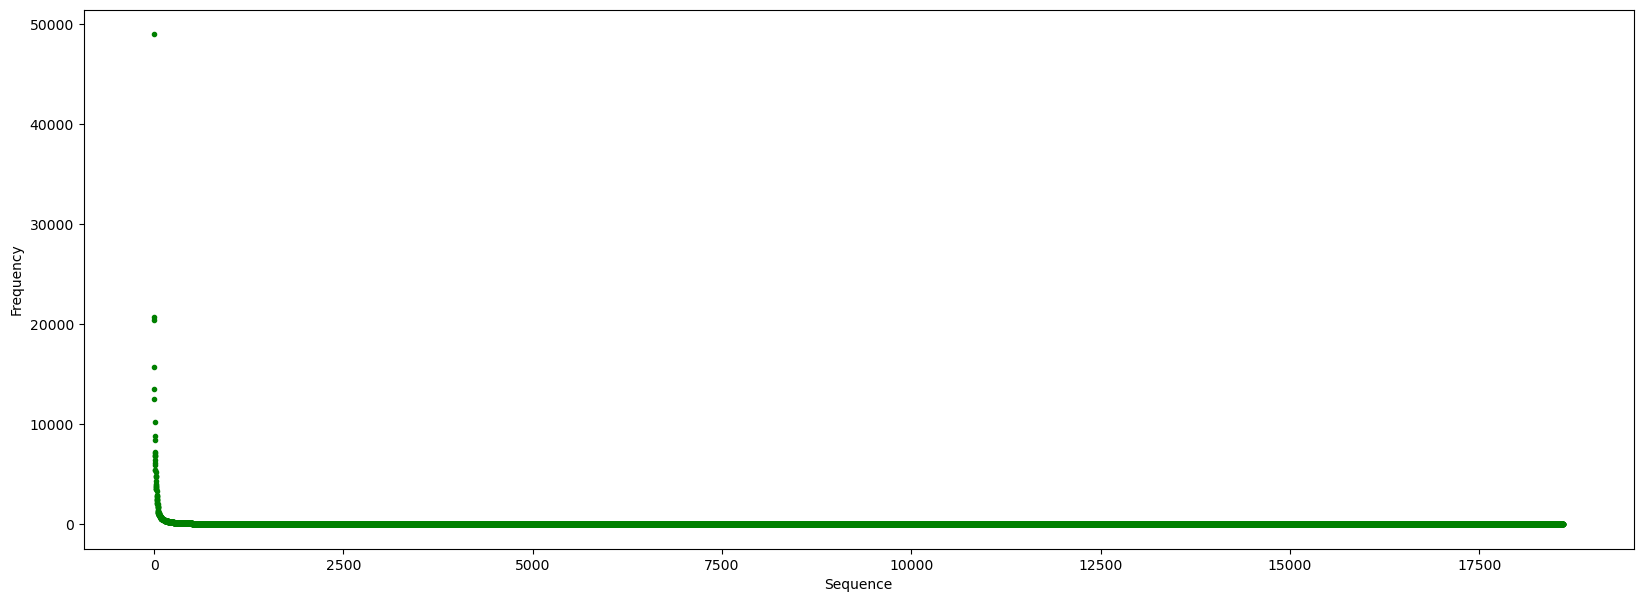

,id,expense_description,amount,expense_code,expense_class_by_code,expense_class_by_expert,description,class,y_class,binary_class,y_binary_class
0,67968997,proveniente de despesa com servicos tecnicos e...,7400.00,33903401,AJ,AC,proveniente de despesa com servicos tecnicos e...,AC,0,Y,1
1,67882216,despesa que se empenha proveniente ao 3º termo...,14498.00,33903499,OUTROS,AC,despesa que se empenha proveniente ao 3o termo...,AC,0,Y,1
...,...,...,...,...,...,...,...,...,...,...,...
17114,68239015,valor que se empenha para ocorrer a despesa co...,1293.00,33903026,N,N,valor que se empenha para ocorrer a despesa co...,N,3,N,0
17115,68345685,despesa com pagamento de bolsa de estudo (parc...,3885.61,33903608,N,N,despesa com pagamento de bolsa de estudo (parc...,N,3,N,0


In [5]:
loaded_data = load_data("tcm_expenses.xlsx")
freq = words_frequency(loaded_data, 'description').sort_values(by=['Frequency'], ascending=False,
                                                                                        ignore_index=True)
print('\n')
words_distribution(loaded_data, 'description')
words_scatter(freq)
loaded_data

In [6]:
loaded_data['class'].value_counts()

N         13786
PA_PIP     2423
CRED        690
AC          123
AJ           94
Name: class, dtype: int64

In [7]:
loaded_data['class'].value_counts(normalize=True).round(4)

N         0.8054
PA_PIP    0.1416
CRED      0.0403
AC        0.0072
AJ        0.0055
Name: class, dtype: float64

In [8]:
loaded_data['binary_class'].value_counts()

N    14476
Y     2640
Name: binary_class, dtype: int64

In [9]:
loaded_data['binary_class'].value_counts(normalize=True).round(3)

N    0.846
Y    0.154
Name: binary_class, dtype: float64

# Preprocessing

In [ ]:
all_dataset = data_cleaning(loaded_data, 'description', 
                            remove_stop_words=True, minimal_characters=4, 
                            minimal_occurrence = 4)
frequency_after_data_cleaning = words_frequency(all_dataset, 'description').sort_values(by=['Frequency'], ascending=False,
                                                              ignore_index=True)
print('\n')
words_distribution(all_dataset, 'description')
words_scatter(frequency_after_data_cleaning)

Minimal occurrence:  4
8239


In [11]:
all_dataset

,id,expense_description,amount,expense_code,expense_class_by_code,expense_class_by_expert,description,class,y_class,binary_class,y_binary_class
0,67968997,proveniente de despesa com servicos tecnicos e...,7400.00,33903401,AJ,AC,proveniente servicos tecnicos especializados a...,AC,0,Y,1
1,67882216,despesa que se empenha proveniente ao 3º termo...,14498.00,33903499,OUTROS,AC,proveniente contrato prestacao servicos tecnic...,AC,0,Y,1
...,...,...,...,...,...,...,...,...,...,...,...
17114,68239015,valor que se empenha para ocorrer a despesa co...,1293.00,33903026,N,N,aquisicao materiais diversos destinados manute...,N,3,N,0
17115,68345685,despesa com pagamento de bolsa de estudo (parc...,3885.61,33903608,N,N,pagamento bolsa estudo (parcela unica) program...,N,3,N,0


In [13]:
classes = {'multiclass': ['y_class', lbl_multiclass]}
seeds = range(0,10)

dados_externos = list()

for seed in seeds:
    
    #Divide all dataset in train and test set
    train_, test_ = train_test_split(all_dataset, test_size=0.2, shuffle=True, random_state=seed)
   
    dados_externos.append(pd.DataFrame(test_.expense_class_by_expert.value_counts()))    

In [14]:
a = pd.concat(dados_externos)
a

,count
expense_class_by_expert,
N,2725
PA_PIP,457
...,...
AC,27
AJ,14


In [15]:
a['sigla'] = a.index
a.groupby(['sigla']).sum()

,count
sigla,
AC,264
AJ,196
CRED,1360
N,27259
PA_PIP,4661


In [16]:
test_.expense_class_by_expert.value_counts()

expense_class_by_expert
N         2753
PA_PIP     457
CRED       123
AC          27
AJ          14
Name: count, dtype: int64

# Experiment

In [27]:
#Models
model = SVC(probability=True, random_state=10)
semi_model = SelfTrainingClassifier(base_estimator=model, max_iter=100)

#Definitions
classes = {'multiclass': ['y_class', lbl_multiclass]}
seeds = range(0,10)

#result variables
metrics_cross_sup  = list()
metrics_cross_semi = list()
metrics_cross_author_semi = list()
metrics_test_set = list()
metrics_test_semi = list()
metrics_test_author_semi = list()

for seed in seeds:
    
    #Divide all dataset in train and test set
    train_, test_ = train_test_split(all_dataset, test_size=0.2, shuffle=True, random_state=seed)
    
    #Select 47 instances of each class and discard other
    # 47 * 5 = 235 instances
    dataset = sampling_instances_by_class(train_, lbl_multiclass.classes_, random=seed)
    
    #unlabeled data
    unlabeled_data = train_[~train_.id.isin(dataset.id)]
    unlabeled_data['y_class'] = -1
    
    print(len(unlabeled_data))
    
    #Split 235 instances in 10 folds
    folds = split_data(dataset, seed=seed)    
    
    #Cross-validation evalution
    for approach, lbl_config in classes.items():
        class_attribute = lbl_config[0]
        encoder = lbl_config[1]
        print('#'*70)
        print('Seed', seed, 'Model: ', model)
        print('EXPERIMENT -> ', 'Model: ', model)
        print('#'*70)
        
        #Supervised prediction
        
        print('SUPERVISED CROSS-VALIDATION')
        folds_return = supervised_cross_validation_prediction(model, folds, class_attribute, lbl_encoder=encoder)
        metrics_model = [seed]
        metrics_model.extend(get_metrics(pd.concat(folds_return), class_attribute, encoder, show=True))
        metrics_cross_sup.append(metrics_model)
        
        
        print('###'*30)
        print('AUTHOR SEMI SUPERVISED CROSS-VALIDATION')
        
        
        #AUTHOR Semisupervised prediction
        folds_author_semi_return = author_semisupervised_cross_validation_prediction(model, folds, 
                                                                            unlabeled_data, 
                                                                            class_attribute, 
                                                                            lbl_encoder=encoder)
        metrics_model = [seed]
        metrics_model.extend(get_metrics(pd.concat(folds_author_semi_return), class_attribute, encoder, show=True))
        metrics_cross_author_semi.append(metrics_model)
        
        
    
    print('###'*30)
    print('SUPERVISED TEST SET')
    
    #Prediction on test set - supervised approach
    results_test_set_seed = test_prediction(model, dataset, test_, class_attribute, lbl_encoder=encoder)
    metrics_test_set.append(results_test_set_seed)
    
    
    
    print('###'*30)
    print('AUTHOR SEMI SUPERVISED TEST SET')
    #Prediction on test set - AUTHOR SEMIsupervised approach

    author_model, vectorizer = author_self_training(model, dataset, unlabeled_data, 
                                                    class_attribute, max_iter=100, verbose=True  )
    semi_results_author_test_set_seed = test_author_semi_prediction(author_model, vectorizer, test_, 
                                                             class_attribute, lbl_encoder=encoder)
    metrics_test_author_semi.append(semi_results_author_test_set_seed)
      
       

13259
Splitint the dataset into k= 10
######################################################################
Seed 0 Model:  SVC(probability=True, random_state=10)
EXPERIMENT ->  Model:  SVC(probability=True, random_state=10)
######################################################################
SUPERVISED CROSS-VALIDATION

 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED   N  PA_PIP
AC      44   1     1   0       0
AJ       2  45     0   0       0
CRED     0   0    45   1       0
N        1   1     1  42       3
PA_PIP   0   0     0   4      44



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

          AC       0.96      0.94      0.95        47
          AJ       0.96      0.96      0.96        47
        CRED       0.98      0.96      0.97        47
           N       0.88      0.89      0.88        47
      PA_PIP       0.92      0.94      0.93        47

    accuracy            

8 13321 3417
9 13322 3417
Iteration; Instances labeled; Total tokens
1 211 683
2 9859 3350
3 12713 3409
4 13204 3417
5 13284 3417
6 13307 3417
7 13313 3417
8 13315 3417
Iteration; Instances labeled; Total tokens
1 211 675
2 9637 3327
3 12649 3414
4 13187 3416
5 13276 3416
6 13295 3416
7 13302 3416
8 13304 3416
9 13306 3416
Iteration; Instances labeled; Total tokens
1 211 683
2 9987 3354
3 12735 3414
4 13255 3417
5 13331 3417
6 13354 3417
7 13363 3417
8 13366 3417
Iteration; Instances labeled; Total tokens
1 211 687
2 10382 3368
3 12715 3415
4 13210 3417
5 13288 3417
6 13316 3417
7 13327 3417
8 13329 3417
9 13333 3417
10 13334 3417
11 13335 3417
Iteration; Instances labeled; Total tokens
1 212 679
2 9890 3357
3 12693 3410
4 13228 3417
5 13305 3417
6 13327 3417
7 13336 3417
8 13339 3417
9 13342 3417
Iteration; Instances labeled; Total tokens
1 212 671
2 10064 3349
3 12764 3408
4 13244 3417
5 13308 3417
6 13324 3417
7 13328 3417
8 13330 3417
9 13333 3417
10 13334 3417
Iteration; Instances

End of iteration 1 added 9311 new labels.
2 9546 3315
End of iteration 2 added 3102 new labels.
3 12648 3409
End of iteration 3 added 613 new labels.
4 13261 3417
End of iteration 4 added 93 new labels.
5 13354 3417
End of iteration 5 added 25 new labels.
6 13379 3417
End of iteration 6 added 9 new labels.
7 13388 3417
End of iteration 7 added 7 new labels.
8 13395 3417
No labels added

 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED     N  PA_PIP
AC      21   0     0     0       0
AJ       1  20     0    18       0
CRED     0   0   125    72       2
N        2   1    10  2495      25
PA_PIP   0   0     1   116     465



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

          AC       1.00      0.88      0.93        24
          AJ       0.51      0.95      0.67        21
        CRED       0.63      0.92      0.75       136
           N       0.98      0.92      0.95      2701
  

2 10015 3332
3 12727 3416
4 13244 3417
5 13337 3417
6 13365 3417
7 13371 3417
8 13376 3417
Iteration; Instances labeled; Total tokens
1 211 650
2 9697 3322
3 12683 3416
4 13234 3417
5 13313 3417
6 13347 3417
7 13358 3417
8 13360 3417
Iteration; Instances labeled; Total tokens
1 211 653
2 9463 3301
3 12575 3414
4 13223 3416
5 13318 3416
6 13344 3416
7 13348 3416
8 13350 3416
9 13352 3416
10 13354 3416
11 13361 3416
12 13363 3416
Iteration; Instances labeled; Total tokens
1 211 671
2 9593 3316
3 12652 3416
4 13220 3416
5 13315 3416
6 13334 3416
7 13338 3416
8 13343 3416
Iteration; Instances labeled; Total tokens
1 211 660
2 9640 3314
3 12641 3415
4 13229 3417
5 13308 3417
6 13335 3417
7 13341 3417
8 13343 3417
Iteration; Instances labeled; Total tokens
1 212 658
2 9557 3313
3 12675 3416
4 13232 3416
5 13308 3416
6 13328 3416
7 13337 3416
8 13342 3417
9 13343 3417
10 13344 3417
Iteration; Instances labeled; Total tokens
1 212 653
2 9206 3281
3 12674 3415
4 13233 3416
5 13309 3416
6 13322 

End of iteration 1 added 10078 new labels.
2 10313 3353
End of iteration 2 added 2430 new labels.
3 12743 3417
End of iteration 3 added 554 new labels.
4 13297 3417
End of iteration 4 added 71 new labels.
5 13368 3417
End of iteration 5 added 18 new labels.
6 13386 3417
End of iteration 6 added 7 new labels.
7 13393 3417
End of iteration 7 added 4 new labels.
8 13397 3417
No labels added

 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED     N  PA_PIP
AC      24   0     1     1       0
AJ       1  13     0    11       0
CRED     0   0   126    71       1
N        4   4     8  2532      36
PA_PIP   0   0     0   127     414



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

          AC       0.92      0.83      0.87        29
          AJ       0.52      0.76      0.62        17
        CRED       0.64      0.93      0.76       135
           N       0.98      0.92      0.95      2742


2 8817 3271
3 12478 3405
4 13222 3416
5 13294 3416
6 13313 3416
7 13315 3416
Iteration; Instances labeled; Total tokens
1 211 640
2 9357 3299
3 12580 3415
4 13243 3416
5 13307 3416
6 13321 3416
7 13334 3416
8 13341 3416
Iteration; Instances labeled; Total tokens
1 211 654
2 9402 3310
3 12640 3402
4 13274 3416
5 13342 3416
6 13356 3416
7 13359 3416
8 13364 3416
9 13365 3416
10 13366 3416
11 13367 3416
Iteration; Instances labeled; Total tokens
1 211 645
2 9201 3309
3 12597 3412
4 13227 3416
5 13303 3416
6 13324 3416
7 13334 3416
8 13335 3416
9 13338 3416
10 13339 3416
11 13340 3416
Iteration; Instances labeled; Total tokens
1 211 650
2 9344 3312
3 12611 3411
4 13256 3416
5 13329 3416
6 13352 3416
7 13358 3416
8 13361 3416
9 13362 3416
10 13364 3416
Iteration; Instances labeled; Total tokens
1 212 647
2 9486 3324
3 12521 3411
4 13216 3416
5 13290 3416
6 13307 3416
7 13314 3416
8 13320 3416
9 13321 3416
10 13322 3416
11 13323 3416
Iteration; Instances labeled; Total tokens
1 212 643
2 935

7 13350 3416
8 13355 3416
9 13356 3416
10 13357 3416

 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED   N  PA_PIP
AC      45   3     0   0       0
AJ       0  39     0   0       0
CRED     1   0    41   1       0
N        1   5     6  46      10
PA_PIP   0   0     0   0      37



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

          AC       0.94      0.96      0.95        47
          AJ       1.00      0.83      0.91        47
        CRED       0.95      0.87      0.91        47
           N       0.68      0.98      0.80        47
      PA_PIP       1.00      0.79      0.88        47

    accuracy                           0.89       235
   macro avg       0.91      0.89      0.89       235
weighted avg       0.91      0.89      0.89       235

-------------------- GENERAL METRICS --------------------

Accuracy 0.89 ; Precision 0.91 ; Recall 0.89 ; F-Score 0.89


###########

End of iteration 1 added 10024 new labels.
2 10259 3349
End of iteration 2 added 2502 new labels.
3 12761 3416
End of iteration 3 added 515 new labels.
4 13276 3417
End of iteration 4 added 67 new labels.
5 13343 3417
End of iteration 5 added 19 new labels.
6 13362 3417
End of iteration 6 added 5 new labels.
7 13367 3417
End of iteration 7 added 2 new labels.
8 13369 3417
End of iteration 8 added 1 new labels.
9 13370 3417
End of iteration 9 added 1 new labels.
10 13371 3417
No labels added

 -------------------- CONFUSION MATRIX -------------------- 

        AC  AJ  CRED     N  PA_PIP
AC      27   0     0     2       0
AJ       0  10     0     8       0
CRED     0   0   118   128       3
N        0   4     4  2541      39
PA_PIP   0   0     1    74     415



------------------ CLASSIFICATION REPORT ------------------

               precision    recall  f1-score   support

          AC       0.93      1.00      0.96        27
          AJ       0.56      0.71      0.63        14
   

# Resumos dos resultados do Sup vs Semi

In [28]:
pd.set_option('display.max_rows', None)

#Show cross-validation metrics in dataframe
df_columns = ['Seed', 'Accuracy', 'Precision', 
              'Recall', 'F1', 'Metrics_by_class', 'Confusion_matrix']

label_x = pd.DataFrame(range(0,10), columns=['X'])
label_x.X = label_x.X.apply(lambda x: ('Repetição ' + str(x+1)))

## Cross-validation

### Supervised

In [29]:
df_metrics_cross_sup = pd.DataFrame(metrics_cross_sup, columns=df_columns).set_index('Seed')


for lbl in lbl_multiclass.classes_:
    #df_metrics_cross_sup[lbl+'_P'] = df_metrics_cross_sup.Metrics_by_class.apply(lambda x:x[lbl]['precision'])
    #df_metrics_cross_sup[lbl+'_R'] = df_metrics_cross_sup.Metrics_by_class.apply(lambda x:x[lbl]['recall'])
    df_metrics_cross_sup[lbl+'_F1'] = df_metrics_cross_sup.Metrics_by_class.apply(lambda x:x[lbl]['f1-score'])

df_metrics_cross_sup.drop(columns=['Metrics_by_class'], inplace=True)
df_metrics_cross_sup.round(2)

,Accuracy,Precision,Recall,F1,Confusion_matrix,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Seed,,,,,,,,,,
0,0.94,0.94,0.94,0.94,"[44, 2, 0, 1, 0, 1, 45, 0, 1, 0, 1, 0, 45, 1, ...",0.95,0.96,0.97,0.88,0.93
1,0.91,0.91,0.91,0.91,"[43, 2, 0, 2, 0, 2, 44, 0, 1, 0, 0, 0, 44, 3, ...",0.92,0.94,0.92,0.85,0.93
2,0.90,0.90,0.90,0.90,"[44, 2, 0, 1, 0, 3, 40, 1, 3, 0, 0, 0, 43, 3, ...",0.94,0.89,0.91,0.82,0.93
3,0.89,0.89,0.89,0.88,"[45, 1, 1, 0, 0, 4, 40, 2, 1, 0, 0, 0, 44, 3, ...",0.93,0.91,0.88,0.80,0.90
4,0.91,0.92,0.91,0.92,"[42, 3, 0, 2, 0, 3, 41, 0, 3, 0, 0, 0, 46, 1, ...",0.90,0.89,0.99,0.86,0.94
5,0.89,0.89,0.89,0.89,"[41, 5, 0, 1, 0, 4, 39, 1, 3, 0, 0, 0, 44, 2, ...",0.89,0.86,0.94,0.84,0.90
6,0.92,0.93,0.92,0.92,"[43, 4, 0, 0, 0, 1, 43, 0, 3, 0, 0, 0, 44, 3, ...",0.95,0.91,0.97,0.87,0.92
7,0.88,0.88,0.88,0.88,"[44, 2, 1, 0, 0, 2, 40, 2, 2, 1, 0, 0, 45, 2, ...",0.94,0.90,0.90,0.78,0.86
8,0.89,0.90,0.89,0.89,"[46, 0, 0, 1, 0, 6, 38, 1, 2, 0, 1, 1, 40, 5, ...",0.92,0.87,0.88,0.83,0.95


In [30]:
mean_cm(df_metrics_cross_sup)

,AC,AJ,CRED,N,PA_PIP
AC,43.5,2.9,0.2,0.6,0.0
AJ,2.5,41.3,0.2,0.4,0.0
CRED,0.2,0.7,43.9,2.2,0.4
N,0.8,2.0,2.5,40.9,3.7
PA_PIP,0.0,0.1,0.2,2.9,42.9


In [31]:
df_metrics_cross_sup[['F1','AC_F1','AJ_F1', 'CRED_F1', 'N_F1', 'PA_PIP_F1']].round(2)

,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Seed,,,,,,
0,0.94,0.95,0.96,0.97,0.88,0.93
1,0.91,0.92,0.94,0.92,0.85,0.93
2,0.90,0.94,0.89,0.91,0.82,0.93
3,0.88,0.93,0.91,0.88,0.80,0.90
4,0.92,0.90,0.89,0.99,0.86,0.94
5,0.89,0.89,0.86,0.94,0.84,0.90
6,0.92,0.95,0.91,0.97,0.87,0.92
7,0.88,0.94,0.90,0.90,0.78,0.86
8,0.89,0.92,0.87,0.88,0.83,0.95


df_metrics_cross_sup['Confusion_matrix'] = df_metrics_cross_sup['Confusion_matrix'].apply(lambda l: l.ravel())

In [32]:
#summary cross-validation metrics
df_metrics_cross_sup.describe()[1:3].round(2)

,Accuracy,Precision,Recall,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
mean,0.90,0.91,0.90,0.90,0.92,0.90,0.93,0.84,0.92
std,0.02,0.02,0.02,0.02,0.02,0.03,0.04,0.03,0.03


In [54]:
df_metrics_cross_sup.to_excel("results/13-07-23-supervised_cross.xlsx")

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

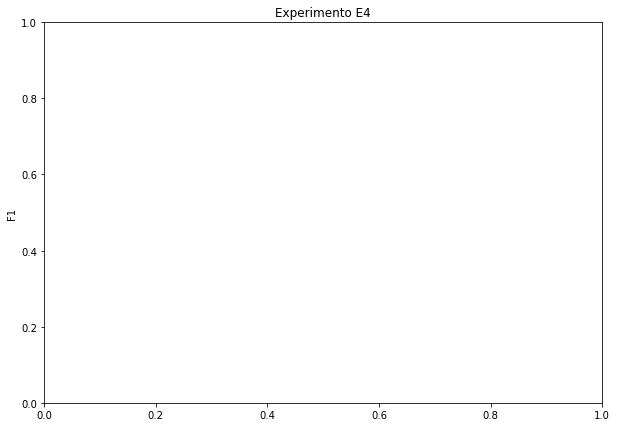

In [34]:
f = plt.figure(figsize=(10, 7)) 
plt.title('Experimento E4')
plt.ylabel('F1')
plt.plot(label_x.X, df_metrics_cross_sup.F1, marker="x",c='orange', label='F1 Geral')
plt.plot(label_x.X, df_metrics_cross_sup.AC_F1, marker=".",c='blue', label='F1 da classe AC')
plt.plot(label_x.X, df_metrics_cross_sup.AJ_F1, marker=".",c='brown', label='F1 da classe AJ')
plt.plot(label_x.X, df_metrics_cross_sup.CRED_F1, marker=".",c='black', label='F1 da classe CRED')
plt.plot(label_x.X, df_metrics_cross_sup.N_F1, marker=".",c='red', label='F1 da classe N')
plt.plot(label_x.X, df_metrics_cross_sup.PA_PIP_F1, marker=".",c='green', label='F1 da classe PA_PIP')
plt.grid(True)
plt.legend(bbox_to_anchor = (1.01,0.90))
plt.yticks(np.arange(0.8, 1.01, 0.01))
f.autofmt_xdate()
plt.show()

## AuthorSelfTraining

In [55]:
df_metrics_cross_author_semi = pd.DataFrame(metrics_cross_author_semi, columns=df_columns).set_index('Seed')


for lbl in lbl_multiclass.classes_:
    #df_metrics_cross_semi[lbl+'_P'] = df_metrics_cross_semi.Metrics_by_class.apply(lambda x:x[lbl]['precision'])
    #df_metrics_cross_semi[lbl+'_R'] = df_metrics_cross_semi.Metrics_by_class.apply(lambda x:x[lbl]['recall'])
    df_metrics_cross_author_semi[lbl+'_F1'] = df_metrics_cross_author_semi.Metrics_by_class.apply(lambda x:x[lbl]['f1-score'])

df_metrics_cross_author_semi.drop(columns=['Metrics_by_class'], inplace=True)
df_metrics_cross_author_semi.round(2)

,Accuracy,Precision,Recall,F1,Confusion_matrix,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Seed,,,,,,,,,,
0,0.91,0.92,0.91,0.92,"[43, 2, 1, 1, 0, 1, 42, 0, 4, 0, 0, 0, 44, 3, ...",0.95,0.92,0.96,0.85,0.91
1,0.88,0.89,0.88,0.88,"[43, 2, 0, 2, 0, 3, 42, 0, 2, 0, 0, 0, 40, 7, ...",0.92,0.92,0.87,0.80,0.90
2,0.89,0.91,0.89,0.90,"[44, 2, 0, 1, 0, 1, 40, 0, 6, 0, 1, 0, 42, 4, ...",0.95,0.90,0.91,0.81,0.92
3,0.88,0.89,0.88,0.88,"[46, 0, 1, 0, 0, 1, 39, 1, 6, 0, 1, 0, 41, 5, ...",0.97,0.91,0.87,0.78,0.87
4,0.91,0.92,0.91,0.91,"[41, 2, 0, 4, 0, 1, 42, 0, 4, 0, 0, 0, 44, 3, ...",0.92,0.91,0.96,0.82,0.93
5,0.88,0.90,0.88,0.88,"[43, 2, 0, 2, 0, 3, 39, 0, 5, 0, 0, 0, 41, 5, ...",0.92,0.89,0.93,0.80,0.88
6,0.90,0.92,0.90,0.91,"[45, 1, 0, 1, 0, 3, 39, 0, 5, 0, 0, 0, 41, 6, ...",0.95,0.90,0.92,0.83,0.93
7,0.88,0.89,0.88,0.88,"[41, 2, 1, 3, 0, 2, 38, 2, 5, 0, 0, 0, 45, 2, ...",0.91,0.87,0.93,0.79,0.89
8,0.89,0.91,0.89,0.89,"[45, 0, 1, 1, 0, 3, 39, 0, 5, 0, 0, 0, 41, 6, ...",0.95,0.91,0.91,0.80,0.88


In [56]:
df_metrics_cross_author_semi.to_excel("results/13-07-23-semisupervised_cross.xlsx")

In [37]:
df_metrics_cross_author_semi[['F1','AC_F1','AJ_F1', 'CRED_F1', 'N_F1', 'PA_PIP_F1']].round(2)

,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Seed,,,,,,
0,0.92,0.95,0.92,0.96,0.85,0.91
1,0.88,0.92,0.92,0.87,0.80,0.90
2,0.90,0.95,0.90,0.91,0.81,0.92
3,0.88,0.97,0.91,0.87,0.78,0.87
4,0.91,0.92,0.91,0.96,0.82,0.93
5,0.88,0.92,0.89,0.93,0.80,0.88
6,0.91,0.95,0.90,0.92,0.83,0.93
7,0.88,0.91,0.87,0.93,0.79,0.89
8,0.89,0.95,0.91,0.91,0.80,0.88


In [38]:
mean_cm(df_metrics_cross_author_semi)

,AC,AJ,CRED,N,PA_PIP
AC,43.4,1.9,0.2,0.0,0.0
AJ,1.5,40.3,0.0,0.1,0.0
CRED,0.4,0.3,42.1,1.5,0.3
N,1.7,4.5,4.6,44.0,6.6
PA_PIP,0.0,0.0,0.1,1.4,40.1


In [39]:
df_metrics_cross_author_semi[['F1','AC_F1','AJ_F1','CRED_F1','N_F1','PA_PIP_F1']].describe()[1:3]

,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
mean,0.897000,0.938143,0.906329,0.919344,0.811938,0.905008
std,0.017029,0.017064,0.018378,0.029789,0.022253,0.023965


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

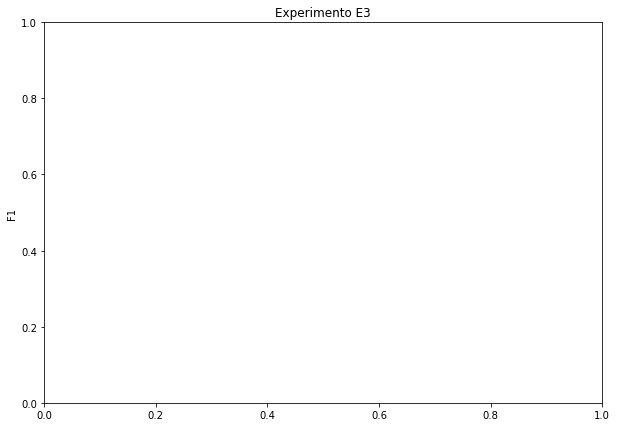

In [40]:
f = plt.figure(figsize=(10, 7)) 
plt.title('Experimento E3')
plt.ylabel('F1')
plt.plot(label_x.X, df_metrics_cross_author_semi.F1, marker="x",c='orange', label='F1 Geral')
plt.plot(label_x.X, df_metrics_cross_author_semi.AC_F1, marker=".",c='blue', label='F1 da classe AC')
plt.plot(label_x.X, df_metrics_cross_author_semi.AJ_F1, marker=".",c='brown', label='F1 da classe AJ')
plt.plot(label_x.X, df_metrics_cross_author_semi.CRED_F1, marker=".",c='black', label='F1 da classe CRED')
plt.plot(label_x.X, df_metrics_cross_author_semi.N_F1, marker=".",c='red', label='F1 da classe N')
plt.plot(label_x.X, df_metrics_cross_author_semi.PA_PIP_F1, marker=".",c='green', label='F1 da classe PA_PIP')
plt.grid(True)
plt.legend(bbox_to_anchor = (1.01,0.90))
plt.yticks(np.arange(0.7, 1.01, 0.02))
f.autofmt_xdate()
plt.show()

# Test set metrics

### Supervised

In [41]:
df_test_set_metrics = pd.DataFrame(metrics_test_set, columns=df_columns).set_index('Seed')

for lbl in lbl_multiclass.classes_:
    #df_test_set_metrics[lbl+'_P'] = df_test_set_metrics.Metrics_by_class.apply(lambda x:x[lbl]['precision'])
    #df_test_set_metrics[lbl+'_R'] = df_test_set_metrics.Metrics_by_class.apply(lambda x:x[lbl]['recall'])
    df_test_set_metrics[lbl+'_F1'] = df_test_set_metrics.Metrics_by_class.apply(lambda x:x[lbl]['f1-score'])

df_test_set_metrics.drop(columns=['Metrics_by_class'], inplace=True)
df_test_set_metrics.round(2)

,Accuracy,Precision,Recall,F1,Confusion_matrix,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Seed,,,,,,,,,,
0,0.85,0.56,0.90,0.66,"[26, 1, 0, 1, 0, 2, 16, 1, 0, 0, 1, 0, 143, 1,...",0.50,0.52,0.58,0.90,0.79
1,0.88,0.62,0.90,0.71,"[20, 2, 0, 0, 0, 1, 25, 1, 2, 0, 0, 0, 139, 5,...",0.55,0.64,0.65,0.92,0.81
2,0.88,0.58,0.93,0.67,"[22, 2, 0, 0, 0, 0, 21, 0, 0, 0, 0, 2, 128, 5,...",0.59,0.37,0.66,0.92,0.83
3,0.88,0.61,0.93,0.71,"[24, 2, 1, 0, 0, 0, 18, 0, 0, 0, 0, 0, 131, 2,...",0.52,0.65,0.60,0.92,0.85
4,0.89,0.60,0.88,0.70,"[23, 0, 0, 1, 0, 2, 10, 0, 2, 0, 3, 0, 137, 6,...",0.59,0.48,0.67,0.93,0.81
5,0.89,0.62,0.92,0.71,"[27, 1, 0, 1, 0, 0, 16, 0, 1, 0, 2, 1, 126, 6,...",0.66,0.50,0.66,0.93,0.81
6,0.89,0.61,0.90,0.70,"[33, 1, 0, 1, 0, 4, 14, 0, 0, 0, 0, 0, 134, 4,...",0.61,0.47,0.67,0.93,0.84
7,0.87,0.61,0.91,0.70,"[21, 1, 0, 0, 0, 2, 21, 0, 1, 0, 0, 0, 116, 2,...",0.70,0.57,0.51,0.91,0.83
8,0.89,0.59,0.90,0.69,"[24, 2, 0, 0, 0, 0, 19, 0, 3, 0, 3, 1, 127, 7,...",0.52,0.47,0.67,0.93,0.84


In [42]:
df_test_set_metrics.to_excel("results/13-07-23-supervised_teste.xlsx")

In [43]:
df_test_set_metrics[['Accuracy', 'Precision', 
              'Recall', 'F1','AC_F1','AJ_F1', 'CRED_F1', 'N_F1', 'PA_PIP_F1']].round(2)

,Accuracy,Precision,Recall,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Seed,,,,,,,,,
0,0.85,0.56,0.90,0.66,0.50,0.52,0.58,0.90,0.79
1,0.88,0.62,0.90,0.71,0.55,0.64,0.65,0.92,0.81
2,0.88,0.58,0.93,0.67,0.59,0.37,0.66,0.92,0.83
3,0.88,0.61,0.93,0.71,0.52,0.65,0.60,0.92,0.85
4,0.89,0.60,0.88,0.70,0.59,0.48,0.67,0.93,0.81
5,0.89,0.62,0.92,0.71,0.66,0.50,0.66,0.93,0.81
6,0.89,0.61,0.90,0.70,0.61,0.47,0.67,0.93,0.84
7,0.87,0.61,0.91,0.70,0.70,0.57,0.51,0.91,0.83
8,0.89,0.59,0.90,0.69,0.52,0.47,0.67,0.93,0.84


In [44]:
cm(df_test_set_metrics)

,AC,AJ,CRED,N,PA_PIP
AC,247,12,9,320,1
AJ,12,172,4,299,2
CRED,1,2,1298,1506,27
N,4,10,43,23730,383
PA_PIP,0,0,6,1404,4248


In [45]:
mean_cm(df_test_set_metrics)

,AC,AJ,CRED,N,PA_PIP
AC,24.7,1.2,0.9,32.0,0.1
AJ,1.2,17.2,0.4,29.9,0.2
CRED,0.1,0.2,129.8,150.6,2.7
N,0.4,1.0,4.3,2373.0,38.3
PA_PIP,0.0,0.0,0.6,140.4,424.8


In [46]:
#summary cross-validation metrics
df_test_set_metrics[['Accuracy', 'Precision', 
              'Recall', 'F1','AC_F1','AJ_F1', 'CRED_F1', 'N_F1', 'PA_PIP_F1']].describe()[1:3].round(2)

,Accuracy,Precision,Recall,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
mean,0.88,0.60,0.91,0.69,0.58,0.51,0.62,0.92,0.82
std,0.01,0.02,0.02,0.02,0.06,0.09,0.06,0.01,0.02


In [47]:
#summary cross-validation metrics
df_test_set_metrics[['AC_F1','AC_P', 'AC_R']].describe()[1:3]

KeyError: "['AC_P', 'AC_R'] not in index"

### SEMI Supervised

In [48]:
df_metrics_test_author_semi = pd.DataFrame(metrics_test_author_semi, columns=df_columns).set_index('Seed')

for lbl in lbl_multiclass.classes_:
    #df_metrics_test_semi[lbl+'_P'] = df_metrics_test_semi.Metrics_by_class.apply(lambda x:x[lbl]['precision'])
    #df_metrics_test_semi[lbl+'_R'] = df_metrics_test_semi.Metrics_by_class.apply(lambda x:x[lbl]['recall'])
    df_metrics_test_author_semi[lbl+'_F1'] = df_metrics_test_author_semi.Metrics_by_class.apply(lambda x:x[lbl]['f1-score'])

df_metrics_test_author_semi.drop(columns=['Metrics_by_class'], inplace=True)
df_metrics_test_author_semi.round(2)

,Accuracy,Precision,Recall,F1,Confusion_matrix,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Seed,,,,,,,,,,
0,0.90,0.76,0.89,0.81,"[23, 1, 1, 3, 0, 0, 16, 0, 3, 0, 1, 0, 143, 1,...",0.84,0.76,0.70,0.94,0.81
1,0.91,0.83,0.88,0.84,"[17, 1, 1, 3, 0, 0, 24, 0, 5, 0, 0, 0, 137, 7,...",0.87,0.81,0.76,0.94,0.82
2,0.93,0.78,0.92,0.83,"[21, 1, 0, 2, 0, 0, 20, 0, 1, 0, 0, 0, 125, 10...",0.93,0.67,0.75,0.95,0.87
3,0.93,0.80,0.91,0.83,"[21, 4, 0, 2, 0, 0, 17, 0, 1, 0, 0, 0, 131, 2,...",0.88,0.72,0.75,0.96,0.87
4,0.91,0.78,0.86,0.81,"[21, 0, 0, 3, 0, 1, 9, 0, 4, 0, 0, 0, 136, 10,...",0.89,0.64,0.75,0.95,0.83
5,0.92,0.76,0.87,0.81,"[24, 1, 0, 4, 0, 0, 13, 0, 4, 0, 1, 0, 126, 8,...",0.87,0.62,0.76,0.95,0.83
6,0.92,0.77,0.87,0.81,"[29, 0, 0, 6, 0, 1, 13, 0, 4, 0, 0, 0, 131, 7,...",0.85,0.63,0.77,0.95,0.84
7,0.91,0.77,0.91,0.82,"[19, 2, 0, 1, 0, 1, 22, 0, 1, 0, 0, 0, 113, 5,...",0.90,0.77,0.63,0.94,0.85
8,0.92,0.80,0.89,0.84,"[22, 1, 0, 3, 0, 0, 18, 0, 4, 0, 0, 0, 129, 9,...",0.92,0.72,0.75,0.95,0.84


In [49]:
df_metrics_test_author_semi.to_excel("results/13-07-23-semisupervised_teste.xlsx")

In [50]:
df_metrics_test_author_semi[['Accuracy', 'Precision', 
              'Recall', 'F1','AC_F1','AJ_F1', 'CRED_F1', 'N_F1', 'PA_PIP_F1']].round(5)

,Accuracy,Precision,Recall,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
Seed,,,,,,,,,
0,0.90,0.76,0.89,0.81,0.83636,0.76190,0.69586,0.93788,0.81055
1,0.91,0.83,0.88,0.84,0.87179,0.81356,0.75691,0.94434,0.81574
2,0.93,0.78,0.92,0.83,0.93333,0.66667,0.74627,0.95338,0.86592
3,0.93,0.80,0.91,0.83,0.87500,0.72340,0.74644,0.95660,0.87220
4,0.91,0.78,0.86,0.81,0.89362,0.64286,0.74521,0.94501,0.82645
5,0.92,0.76,0.87,0.81,0.87273,0.61905,0.75676,0.95081,0.83468
6,0.92,0.77,0.87,0.81,0.85294,0.63415,0.76833,0.94887,0.83510
7,0.91,0.77,0.91,0.82,0.90476,0.77193,0.63128,0.94361,0.85094
8,0.92,0.80,0.89,0.84,0.91667,0.72000,0.74566,0.95163,0.84359


In [51]:
#summary cross-validation metrics
df_metrics_test_author_semi[['Accuracy', 'Precision', 
              'Recall', 'F1','AC_F1','AJ_F1', 'CRED_F1', 'N_F1', 'PA_PIP_F1']].describe()[1:3].round(2)

,Accuracy,Precision,Recall,F1,AC_F1,AJ_F1,CRED_F1,N_F1,PA_PIP_F1
mean,0.92,0.78,0.89,0.82,0.89,0.70,0.72,0.95,0.84
std,0.01,0.02,0.02,0.01,0.04,0.07,0.05,0.01,0.02


In [52]:
mean_cm(df_metrics_test_author_semi)

,AC,AJ,CRED,N,PA_PIP
AC,22.4,0.3,0.2,1.0,0.0
AJ,1.1,16.2,0.0,8.9,0.0
CRED,0.2,0.0,128.9,90.6,1.7
N,2.7,3.1,6.3,2497.3,31.1
PA_PIP,0.0,0.0,0.6,128.1,433.3


# Discussão

In [53]:
df_comparativo = pd.DataFrame(np.transpose([df_metrics_test_author_semi.F1, df_test_set_metrics.F1]), columns=['F1_Semi', 'F1_Sup'])
df_comparativo['Diferenca'] = df_comparativo.F1_Semi - df_comparativo.F1_Sup
df_comparativo.append(df_comparativo.describe())

AttributeError: 'DataFrame' object has no attribute 'append'

# Múltiplas imagens numa figura

In [ ]:
f = plt.figure(figsize=(20, 7)) 

width=5
height=5
rows = 2
cols = 2
axes = []

axes.append(f.add_subplot(3,3, 1))
axes[-1].set_title('Imagem 1')

plt.plot(label_x.X, df_metrics_test_author_semi.F1, marker=".",c='blue', label='F1 Semi Supervisionado')
plt.plot(label_x.X, df_test_set_metrics.F1, marker="x",c='green', label='F1 Supervisionado')

axes.append(f.add_subplot(3,3, 2))
axes[-1].set_title('Imagem 2')

plt.plot(label_x.X, df_metrics_test_author_semi.AC_F1, marker=".",c='blue', label='F1 Semi Supervisionado')
plt.plot(label_x.X, df_test_set_metrics.AC_F1, marker="x",c='green', label='F1 Supervisionado')

#plt.legend()
#plt.yticks(np.arange(0.7, 1.01, 0.02))
#plt.imshow(a)
f.autofmt_xdate()

plt.show()